In [1]:
import pandas as pd 
import numpy as np 
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
import pingouin as pg
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
with open(r"../../DerivedData/cohorts_subjects_list.pickle", "rb") as input_file:
        cohorts = pickle.load(input_file)
        
outcomes = ['Cognitive Score','Language Score','Motor Score']
n_folds = 46
it_num = 1000

with open(r"../../Results/files/test_prediction_null_distributions.pickle", "rb") as input_file:
        null = pickle.load(input_file)

In [45]:
### eLife parameters 
#-s 4 => svm_type nu-SVR
#-t 0 => kernel type linear
#-c 9 => C parameter
#-g 10 => gamma (of nonlinear)
#-p 0.1 => epsilon (for epsilon-SVR)

In [8]:
def _scaling(X_train, X_test):
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test
    

def train_test(X,y, n_folds, return_values=False, return_weights = False):
    
    loo = KFold(n_splits=n_folds)
    
    y_true = []
    y_pred = []
    
    weight = np.zeros((len(X),len(X[0])))
    
    
    for train_index, test_index in loo.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        # scale
        X_train, X_test = _scaling(X_train= X_train, X_test = X_test)
    
        ### train / test
        clf = NuSVR(C=9, kernel='linear' )
        #clf = GradientBoostingRegressor()
        clf.fit(X_train, y_train)
    
        y_out = clf.predict(X_test)
        for el in range(len(y_test)):
            y_true.append(y_test[el])
            y_pred.append(y_out[el])
            
        #weight[i,:] = clf.coef_


    mae = mean_absolute_error(y_true, y_pred)
    rho, p_val = pg.corr(y_true, y_pred)['r'][0], pg.corr(y_true, y_pred)['p-val'][0]
      
    #feature_contribution = abs(np.mean(weight, axis = 0))/ sum(abs(np.mean(weight, axis =0)))
    feature_contribution = 0
    
    if return_values == True and return_weights == False:
        return mae, rho, y_true, y_pred
    elif return_values == True and return_weights == True:
        return mae, rho, y_true, y_pred, feature_contribution
    else:
        return mae, rho

In [9]:
#res = {}

#for clustering in [128, 256, 512, 1024]: 
for clustering in [128]: 
    print('Running on data: clustering {}'.format(clustering))
    #res[clustering] = {}
    
    df = pd.read_csv('../../DerivedData/extracted_metrics/random_parcellation_{}_diffusion_metric.csv'.format(clustering), index_col=0)

    res = {}
    for cohort in ['A', 'B', 'C', 'D']:
    #for cohort in ['A']:
        
        res[cohort] = {}
        print('Cohort {}'.format(cohort))
        #res[clustering]['Cohort_{}'.format(cohort)] = {}
        
        sub_df = df[df.subject_id.isin(cohorts[cohort])]
        
        scores = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
        scores = scores[scores['subject_id'].isin(cohorts['A'])]

        sub_df = pd.merge(sub_df, scores[['subject_id', 'Cognitive Score','Language Score', 'Motor Score']], on='subject_id')
        
        in_cols = [col for col in df.columns for x in ['FA'] if x in col]
        
        ### shuffle data
        sub_df.sample(frac=1)
        X = sub_df[in_cols].values
        for outcome in outcomes:
            res[cohort][outcome] = {}
            y = sub_df[outcome].values
            
            ## run
            mae, rho, res[cohort][outcome]['y_true'], res[cohort][outcome]['y_pred'], res[cohort][outcome]['f_contribution']  = train_test(X=X,y=y, n_folds=n_folds, return_values=True, return_weights=True)
            
            mae_dist = np.array(null[clustering]['Cohort_{}'.format(cohort)]['Cognitive Score']['MAE']) 
            rho_dist = np.array(null[clustering]['Cohort_{}'.format(cohort)]['Cognitive Score']['RHO']) 
            
            p_mae = len(mae_dist[mae_dist < mae])/len(mae_dist)
            p_rho = len(rho_dist[rho_dist > rho])/len(rho_dist)

            print('{} MAE:{:.3f} ({}) r:{:.3f} ({})'.format(outcome, mae,  p_mae, rho, p_rho))



Running on data: clustering 128
Cohort A
Cognitive Score MAE:9.526 (0.328) r:0.043 (0.321)
Language Score MAE:13.621 (1.0) r:0.016 (0.4)
Motor Score MAE:7.927 (0.009) r:0.074 (0.248)
Cohort B
Cognitive Score MAE:9.554 (0.316) r:0.122 (0.173)
Language Score MAE:13.866 (1.0) r:0.041 (0.338)
Motor Score MAE:8.528 (0.042) r:0.009 (0.444)
Cohort C
Cognitive Score MAE:9.619 (0.335) r:0.112 (0.177)
Language Score MAE:13.719 (1.0) r:0.060 (0.287)
Motor Score MAE:8.424 (0.028) r:0.026 (0.366)
Cohort D
Cognitive Score MAE:7.940 (0.359) r:0.043 (0.344)
Language Score MAE:11.899 (1.0) r:-0.076 (0.662)
Motor Score MAE:6.601 (0.014) r:0.176 (0.094)


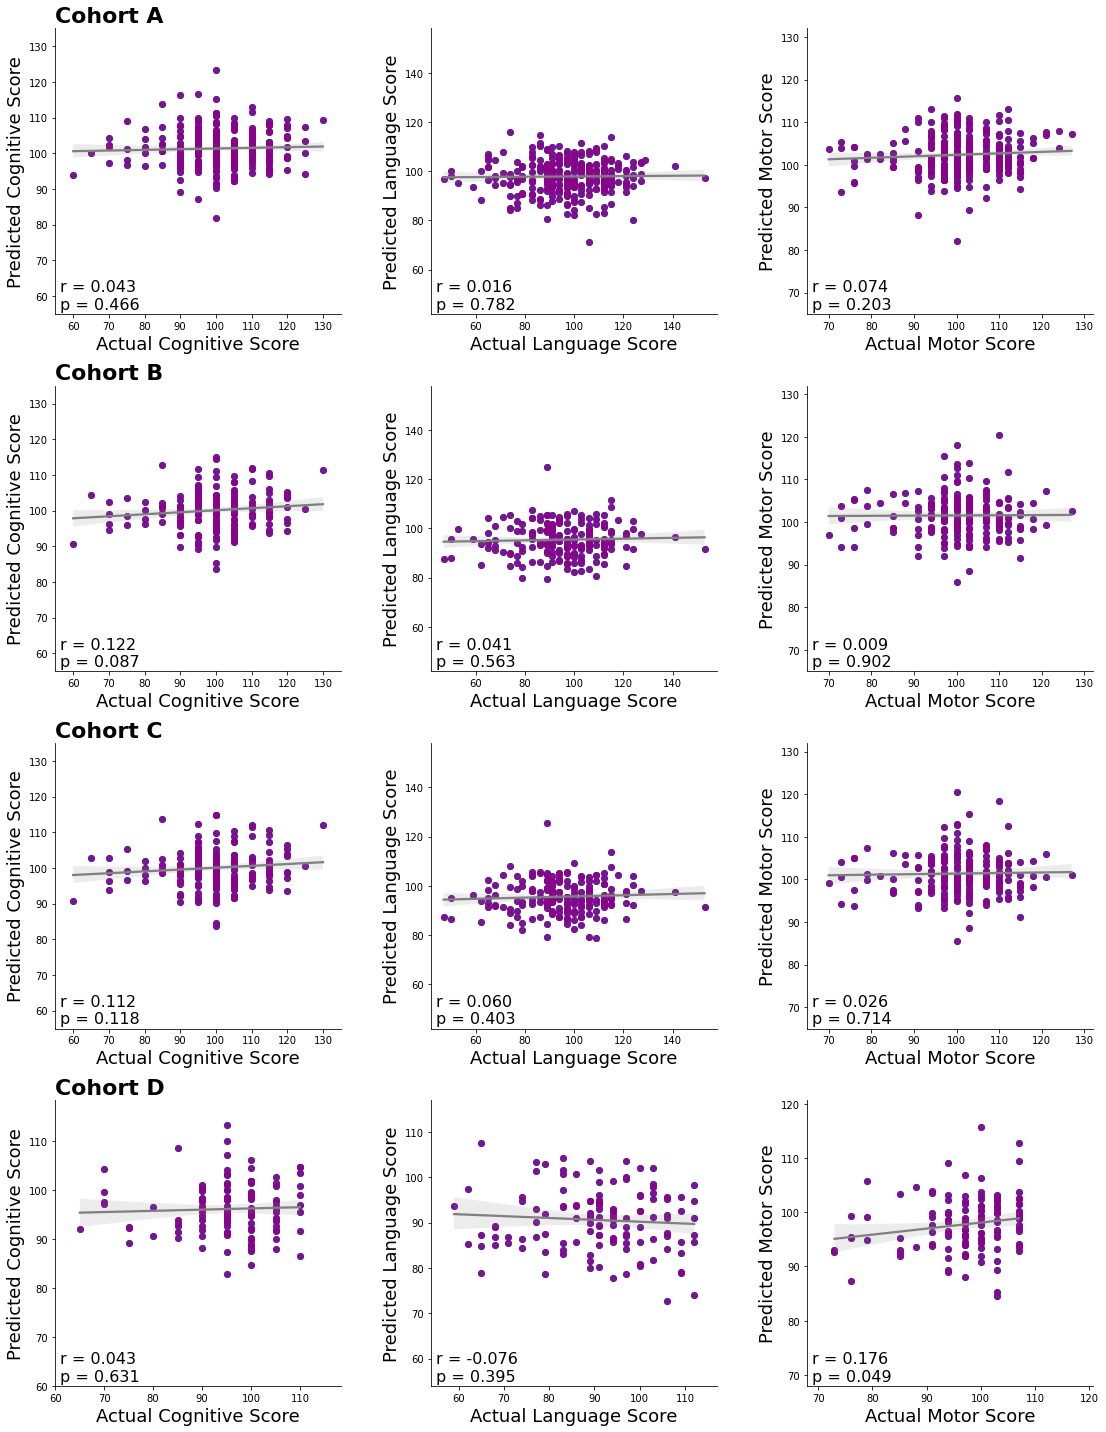

In [10]:
fig, axs = plt.subplots(4,3,sharex=False, sharey=False, figsize=(16,20))

for f,cohort in enumerate(cohorts):
    for i,outcome in enumerate(outcomes):
        axs[f,i].scatter(res[cohort][outcome]['y_true'], res[cohort][outcome]['y_pred'])
    
        if outcome == 'Communication Composite Score':
            label = 'Language Score'
        else:
            label = '{} {}'.format(outcome.split(' ')[0], outcome.split(' ')[-1])

        axs[f,i].set_xlabel('Actual {}'.format(label), fontsize=18)
        axs[f,i].set_ylabel('Predicted {}'.format(label), fontsize=18)
    
        axs[f,i].axis('square')
        a = 5
        lower = np.min([np.min(res[cohort][outcome]['y_true']), np.min(res[cohort][outcome]['y_pred'])]) - a
        upper = np.max([np.max(res[cohort][outcome]['y_true']), np.max(res[cohort][outcome]['y_pred'])]) + a
    
        axs[f,i].set_ylim(lower, upper)
        axs[f,i].set_xlim(lower, upper)
        #axs[i].axis('square')
    
        ## linear regression 
        test = pg.linear_regression(res[cohort][outcome]['y_true'], res[cohort][outcome]['y_pred'])
        sns.regplot(x = res[cohort][outcome]['y_true'], y = res[cohort][outcome]['y_pred'], 
                     ax = axs[f,i], 
               scatter_kws={"color": "darkmagenta"}, line_kws={"color": "gray"})
    
        r, p =  pg.corr(res[cohort][outcome]['y_true'], res[cohort][outcome]['y_pred'])['r'][0], pg.corr(res[cohort][outcome]['y_true'], res[cohort][outcome]['y_pred'])['p-val'][0]
        axs[f,i].annotate('r = {:.3f}\np = {:.3f}'.format(r,p),
            xy=(5, 5), xycoords='axes points', fontsize = 16)
    axs[f,0].set_title('Cohort {}'.format(cohort), fontsize=22, loc='left', fontweight='bold')
for ax in axs.ravel():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
plt.tight_layout()
plt.show()

In [79]:
res[cohort][outcome]['f_contribution']

array([0.00722599, 0.01705508, 0.01760213, 0.00970514, 0.01136172,
       0.00258266, 0.0239988 , 0.0003217 , 0.01366313, 0.01689917,
       0.00277664, 0.0116789 , 0.00370313, 0.01157791, 0.00200182,
       0.01345089, 0.00939174, 0.01755018, 0.00282469, 0.01465149,
       0.00677422, 0.02134323, 0.00797739, 0.00538647, 0.0115249 ,
       0.00225863, 0.00265844, 0.00648023, 0.00816113, 0.01483164,
       0.02191157, 0.00228363, 0.00441072, 0.00157752, 0.01160912,
       0.01412744, 0.01193389, 0.0067573 , 0.00831891, 0.01645693,
       0.00123397, 0.00596762, 0.00044407, 0.00350927, 0.01155222,
       0.01192829, 0.00276052, 0.00286425, 0.01802502, 0.00812382,
       0.01237167, 0.00820144, 0.00902843, 0.00923639, 0.00203036,
       0.02674505, 0.02113184, 0.00615252, 0.00257426, 0.00985924,
       0.02440119, 0.02521685, 0.00311134, 0.00159617, 0.00070144,
       0.00660685, 0.00476475, 0.01583288, 0.00633192, 0.00085452,
       0.00486422, 0.00402908, 0.01218161, 0.01372059, 0.01187